# Lectura de datos y librerias

In [1]:
# librerias
import numpy as np
import pandas as pd
import folium
import gudhi
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from pyproj import Transformer
from scipy.spatial import Delaunay
from sklearn.metrics import pairwise_distances
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from collections import defaultdict

C:\Users\isabe\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv(r"C:\Users\isabe\OneDrive\Escritorio\datos_latlong.csv")
coords_deg = df[['lat','lon']].to_numpy(dtype=float)

In [3]:
# Distancias geodésicas (m) matriz simétrica NXN D[i,j] = distancia entre el accidente i y el accidente j en metros.
def haversine_matrix(latlon_deg):
    # lat/lon en radianes
    lat = np.radians(latlon_deg[:,0])[:,None]
    lon = np.radians(latlon_deg[:,1])[:,None]
    lat_T = lat.T
    lon_T = lon.T
    dlat = lat - lat_T
    dlon = lon - lon_T
    a = np.sin(dlat/2.0)**2 + np.cos(lat) @ np.cos(lat_T) * np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.minimum(1.0, np.sqrt(a)))
    R = 6371000.0
    return R*c

D = haversine_matrix(coords_deg)

# Complejo Vietoris-Rips

In [4]:
# Vietoris–Rips complex a un umbral ε

def build_vr_complex(D, EPS):
    N = D.shape[0]
    # 1-símplices: todas las aristas con distancia <= EPS
    edges = [(i, j) for i in range(N) for j in range(i + 1, N) if D[i, j] <= EPS]

    # 2-símplices (triángulos): cliques de 3 nodos con todas sus aristas <= EPS
    neighbors = defaultdict(list) #lista de nodos conectados con el vértice i.
    for i, j in edges:
        neighbors[i].append(j)
        neighbors[j].append(i)

    triangles = []
    for i in range(N):
        nbrs = neighbors[i]
        # intersectar vecinos para buscar pares (j,k) con j<k y ambos conectados entre sí
        for a_idx in range(len(nbrs)):
            j = nbrs[a_idx]
            if j <= i:
                continue
            # intersección de vecinos(i) y vecinos(j)
            cand = set(nbrs).intersection(neighbors[j])
            for k in cand:
                if k <= j:
                    continue
                triangles.append((i, j, k))

    return edges, triangles, neighbors

#visualizacion 
def plot_vr_complex(df, edges, EPS, point_size=4, edge_color='red', alpha=0.4):

    plt.figure(figsize=(6, 5))
    # Puntos (accidentes)
    plt.scatter(df.lon, df.lat, s=point_size, c='gray')

    # Aristas (conexiones del complejo)
    for (i, j) in edges:
        plt.plot(
            [df.lon[i], df.lon[j]],
            [df.lat[i], df.lat[j]],
            c=edge_color,
            lw=0.3,
            alpha=alpha
        )

    plt.title(f"Vietoris–Rips complex (ε = {EPS:.1f} m)")
    plt.xlabel("lon")
    plt.ylabel("lat")
    plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



## Vietoris–Rips ε = 300

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


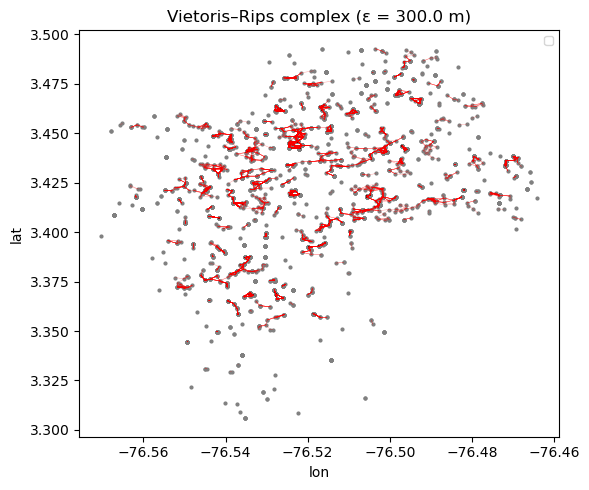

ε = 300.0 m →|V|=3980, |E|=88289, |Δ2|=3370120


In [5]:
EPS = 300.0
edges, triangles, neighbors = build_vr_complex(D, EPS)
plot_vr_complex(df, edges, EPS)

print(f"ε = {EPS} m →|V|={D.shape[0]}, |E|={len(edges)}, |Δ2|={len(triangles)}")

- Se analizaron 3980 accidentes. (V: Accidentes individuales)
- A 300 m, hay 88289 conexiones directas. (E: número de aristas (conexiones a 300 m))
- Se forman 3'370.120 triángulos (Δ2: número de triángulos (cliques de 3 completamente conectados))

## Vietoris–Rips ε = 500

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


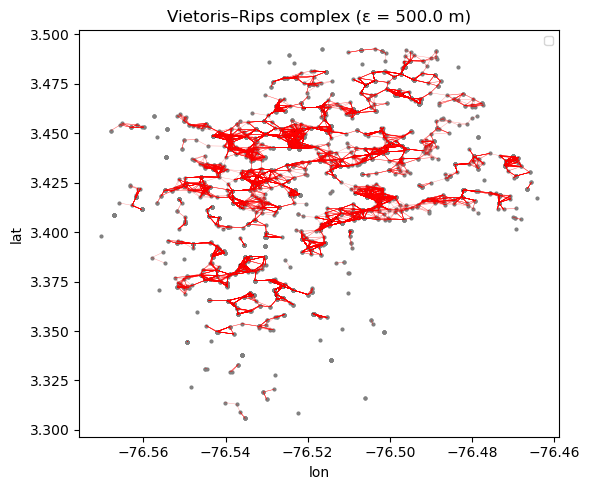

ε = 500.0 m →|V|=3980, |E|=125325, |Δ2|=4526744


In [6]:
EPS = 500.0
edges, triangles, neighbors = build_vr_complex(D, EPS)
plot_vr_complex(df, edges, EPS)

print(f"ε = {EPS} m →|V|={D.shape[0]}, |E|={len(edges)}, |Δ2|={len(triangles)}")

- Se analizaron 3980 accidentes. (V: Accidentes individuales)
- A 500 m, hay 125325 conexiones directas. (E: número de aristas (conexiones a 500 m))
- Se forman 4'526.744 triángulos (Δ2: número de triángulos (cliques de 3 completamente conectados))

## Vietoris–Rips ε = 800

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


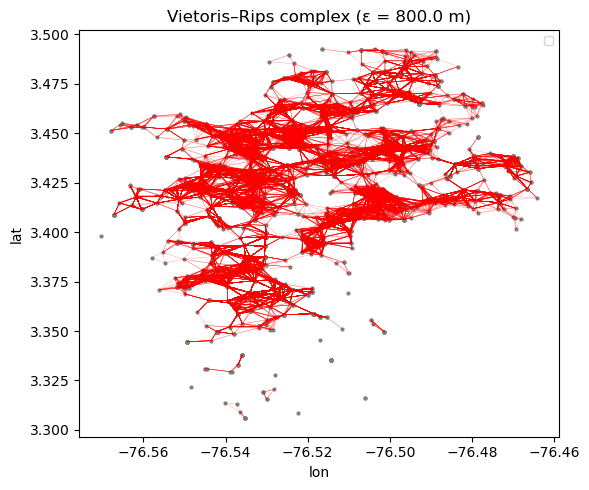

ε = 800.0 m → |E|=219873, |Δ2|=9380779


In [7]:
EPS = 800.0
edges, triangles, neighbors = build_vr_complex(D, EPS)
plot_vr_complex(df, edges, EPS)

print(f"ε = {EPS} m → |E|={len(edges)}, |Δ2|={len(triangles)}")

- Se analizaron 3980 accidentes. (V: Accidentes individuales)
- A 800 m, hay 219873 conexiones directas. (E: número de aristas (conexiones a 800 m))
- Se forman más de 9'380.779 triángulos (Δ2: número de triángulos (cliques de 3 completamente conectados))

# Diagramas de persistencia H0 Y H1

H0 barras: (931, 2) H1 barras: (178, 2)


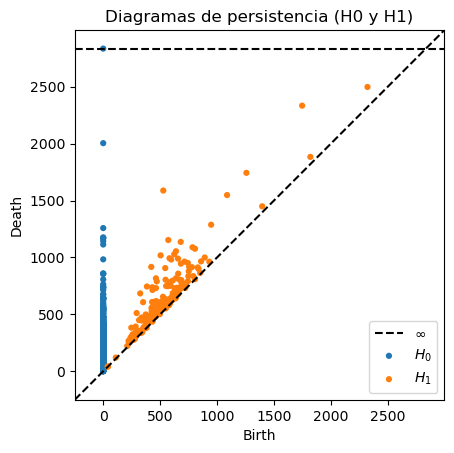

In [8]:
# Homología persistente de la matriz de distancias (H0 y H1)
result = ripser(D, distance_matrix=True, maxdim=1)
diagrams = result['dgms']  # [H0, H1, ...]
print("H0 barras:", diagrams[0].shape, "H1 barras:", diagrams[1].shape)

from persim import plot_diagrams
plot_diagrams(diagrams, show=True, title="Diagramas de persistencia (H0 y H1)")

### H₀ – Conectividad local
- Los puntos azules se concentran en Birth ≈ 0, lo que significa que cada accidente empieza como un punto aislado.

- A medida que aumenta ε (unos cientos de metros), los puntos comienzan a fusionarse: esto revela la escala a la que los accidentes empiezan a formar conglomerados o clústeres urbanos.

- Las barras o puntos con “muerte” muy alta (arriba del gráfico) indican los grupos más grandes y persistentes, típicamente las zonas de mayor concentración de accidentes.

- algunos puntos azules llegan hasta Death ≈ 2700 m, lo cual sugiere que los principales conglomerados de accidentes se unen en escalas de unos 2.5 km

### H₁ – Ciclos o vacíos

- Los puntos naranjas aparecen más dispersos y se alejan de la diagonal hasta Birth ≈ 500 – 1500 m, Death ≈ 1000 – 2500 m.

- Cada punto representa un “agujero topológico”, es decir, un área rodeada de accidentes pero con poca o nula ocurrencia en el centro, pueden ser barrios o parques.

# Diagrama de barras


In [9]:
# diagrama de barras
H0, H1 = diagrams[0], diagrams[1]

def plot_barcode_simple(diagram, dim=0, color='steelblue'):
    finite_bars = diagram[np.isfinite(diagram[:,1])]
    persistences = finite_bars[:,1] - finite_bars[:,0]
    # Ordenar de más largas a más cortas
    order = np.argsort(persistences)[::-1]
    finite_bars = finite_bars[order]
    
    plt.figure(figsize=(8, 5))
    for i, (birth, death) in enumerate(finite_bars):
        plt.plot([birth, death], [i, i], lw=2, color=color)
    plt.xlabel("ε (m)")
    plt.ylabel("Barra #")
    plt.title(f"Barcode H{dim}")
    plt.grid(True, alpha=0.3)
    plt.show()



## H0

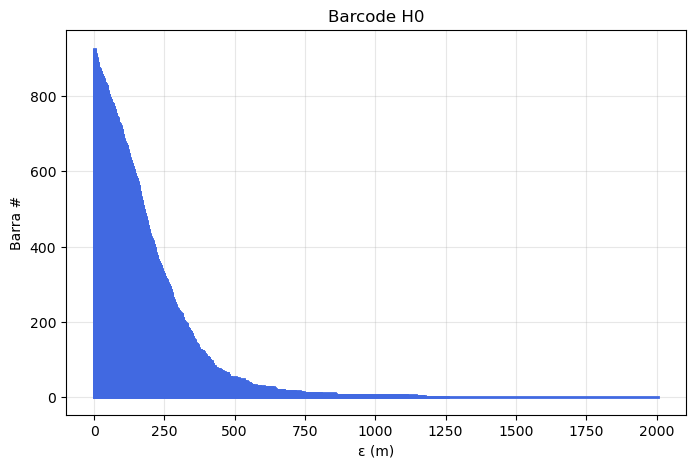

In [10]:
plot_barcode_simple(H0, dim=0, color='royalblue')

Cada barra indica un grupo de accidentes que comienza como un punto aislado y se fusiona con otros al aumentar ε.

Al inicio (ε ≈ 0) hay casi 1000 barras mueren rápidamente, y hacia 500 m quedan muy pocas componentes.

## H1

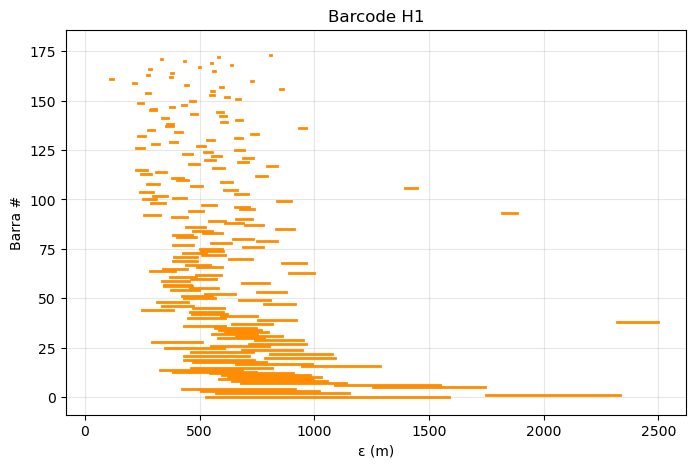

In [11]:
plot_barcode_simple(H1, dim=1, color='darkorange')

Cada barra indica una zona donde los accidentes rodean un vacío.  
Los ciclos comienzan a aparecer desde ε ≈ 300 m hasta unos 1000–1500 m, algunos persisten bastantes.

----------------------------------------------------------------------------------------------------

In [12]:
# clusters
EPS = 500
MIN_SAMPLES = 2 #min de acc para formar 1 cluster

#agrupa puntos densos (accidentes) a partir de la matriz de distancias geodésicas D.
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='precomputed').fit(D) 
df['cluster'] = db.labels_

n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0) #-1 representa ruido (puntos aislados).
print(f"{n_clusters} clusters detectados (ε = {EPS} m)")


# mapa cali
center_lat, center_lon = df['lat'].mean(), df['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodbpositron')

# clusters
colors = cm.get_cmap('tab20', n_clusters)
for k in set(db.labels_):
    cluster_points = df[df['cluster'] == k]
    if k == -1:
        # Ruido (puntos aislados)
        for _, row in cluster_points.iterrows():
            folium.CircleMarker(
                location=(row['lat'], row['lon']),
                radius=2,
                color='gray',
                fill=True, fill_color='gray', fill_opacity=0.4
            ).add_to(m)
    else:
        color = f'#{int(colors(k)[0]*255):02x}{int(colors(k)[1]*255):02x}{int(colors(k)[2]*255):02x}'

        # Puntos del cluster
        for _, row in cluster_points.iterrows():
            folium.CircleMarker(
                location=(row['lat'], row['lon']),
                radius=3,
                color=color,
                fill=True, fill_color=color, fill_opacity=0.8
            ).add_to(m)

        # Centroide del cluster
        mean_lat, mean_lon = cluster_points[['lat','lon']].mean()

        # Etiqueta del cluster
        folium.Marker(
            [mean_lat, mean_lon],
            icon=folium.DivIcon(html=f'<div style="font-size:10px;color:{color}">C{k}</div>')
        ).add_to(m)

m.save("clusters_accidentes.html")


36 clusters detectados (ε = 500 m)


C:\Users\isabe\AppData\Local\Temp\ipykernel_20740\805560404.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_clusters)


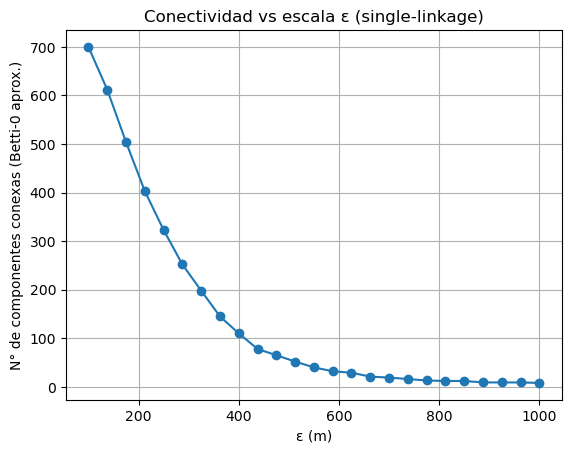

In [ ]:
# estructura Union–Find
N = D.shape[0]
def num_components_vs_eps(D, eps_grid):
    parent = np.arange(N)
    rank = np.zeros(N, dtype=int)
    # busqueda y compresion de caminos
    def find(x):
        while parent[x]!=x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    # union por el rango del arbol
    def union(a,b):
        ra, rb = find(a), find(b)
        if ra==rb: return False
        if rank[ra]<rank[rb]:
            parent[ra]=rb
        elif rank[ra]>rank[rb]:
            parent[rb]=ra
        else:
            parent[rb]=ra
            rank[ra]+=1
        return True

    # lista de todas las aristas posibles (distancias entre accidentes) ordenadas por peso (distancia)
    E = []
    n = D.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            E.append((D[i,j], i, j))
    E.sort(key=lambda x: x[0])  # Kruskal

    # ejecuta en varios epsilon
    comps_per_eps = []
    edge_idx = 0
    for eps in sorted(eps_grid):
        parent = np.arange(N)
        rank = np.zeros(N, dtype=int)
        comps = N
        for w,i,j in E:
            if w>eps: break
            if union(i,j):
                comps -= 1
        comps_per_eps.append((eps, comps))
    return np.array(comps_per_eps)



eps_grid = np.linspace(100, 1000, 25)
curve = num_components_vs_eps(D, eps_grid)


plt.figure()
plt.plot(curve[:,0], curve[:,1], marker='o')
plt.xlabel("ε (m)")
plt.ylabel("N° de componentes conexas")
plt.title("Conectividad vs escala ε (single-linkage)")
plt.grid(True)
plt.show()

- La curva decrece monótonamente, porque conforme aumenta ε, los puntos se van conectando.
- Conforme ε aumenta (200–500 m): los accidentes cercanos empiezan a conectarse → el número de componentes cae abruptamente.
- Más allá de cierto punto (~700–800 m): la curva se aplana → casi todos los accidentes pertenecen a una red continua.
